# Speech Recognotion Exploratory Data Analysis

## Introduction

The exercise involves trying to identify voice from amongst musical instruments.

**Data**
1. 10 Classes of recordings
2. 9 Classes are for musical instruments
3. 1 Class is for human voice
4. Each class has 30 recordings each

**Approach**
1. **Part 1** - Introduction to voice processing and performing a voice exploratory data analysis - 26th October 2019
2. **Part 2** - Train the Model using a recurrent neural net / convolutional neural net - Later Date (to be advertised)
3. **Part 3** - Perform predictions and compare performance - Later Date (to be advertised)
4. **Part 4** - Export model into a pickle file - Later Date (to be advertised)

## Workbench

### Importing the required libraries

In [ ]:
import os
from tqdm import tqdm # This allows you to wrap any iterable in python and it then creates a progress bar for you within jupyter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
!pip install python_speech_features
# python speech features is an audio library
from python_speech_features import mfcc, logfbank

# This is the common audio library
import librosa

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5868 sha256=2d9879e63b17c5fbc0c17d747014d5b6eeeb80338d00da1ecb2f61f6b356e966
  Stored in directory: /root/.cache/pip/wheels/37/01/19/e6c69a32684ab7b2e3ea4985a571d810cf055c72600e7f9f17
Successfully built python_speech_features


### Helper Functions

1. plot_signals -
2. plot_fft -
3. plot_fbank -
4. plot_mfccs -
5. calc_fft -
6. envelop -

In [ ]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [ ]:
def plot_fft(fft):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [ ]:
def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [ ]:
def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [ ]:
# FFT has two parts (magnitude and frequency)
def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate) # This goes to the x-axis with the spaces between the samples (d)
    Y = abs(np.fft.rfft(y)/n) # Generate the magnitude - This is the y-axis. Normalize the length of the signal by dividing by n
    return (Y, freq)

In [ ]:
# Function to detect the estimation of the magnitude i.e. the Amplitude of the signal i.e. if the amplitude is too low
# then it can be stripped off since the audio has died out
# Basically to do Noise Forward Detection of the signal
def envelop(y,rate,threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10),min_periods=1,center=True).mean()

    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)

    return mask

### Import the CSV File

In [27]:
!pip install gdown
import gdown
import pandas as pd

# Google Drive file ID
file_id = "1X_KwaDG8Hb0_b3ArhXZNx5Vma_g_zYQE"

# Download the CSV file
gdown.download(f"https://drive.google.com/uc?id=1X_KwaDG8Hb0_b3ArhXZNx5Vma_g_zYQE", "dataset.csv", quiet=False)

# Read the CSV file
speech_df = pd.read_csv("dataset.csv")

# Display first few rows
speech_df.head()


Downloading...
From: https://drive.google.com/uc?id=1X_KwaDG8Hb0_b3ArhXZNx5Vma_g_zYQE
To: /content/dataset.csv
100%|██████████| 8.06k/8.06k [00:00<00:00, 13.6MB/s]


,fname,label
0,5388d14d.wav,Saxophone
1,c685f05f.wav,Saxophone
2,36d20ab5.wav,Saxophone
3,d6665734.wav,Saxophone
4,7352e28f.wav,Saxophone


### Checkout sample data from the CSV file

In [59]:
import pandas as pd

# Load CSV with correct separator
speech_df = pd.read_csv("dataset.csv", sep=",")

# Clean column names by stripping spaces
speech_df.columns = speech_df.columns.str.strip()

# Verify column names again
print(speech_df.columns)

# Now set the index
speech_df.set_index('fname', inplace=True)



Index(['fname', 'label'], dtype='object')


### Create an index column

### Add a new column and label it length

In [66]:
from google.colab import drive
drive.mount('/content/drive')
import os

base_path = "/content/drive/My Drive/labproject/wavfiles"

if os.path.exists(base_path):
    print("Path exists:", base_path)
    print("Files:", os.listdir(base_path))  # List files inside the folder
else:
    print("Path not found. Check your folder names in Drive.")

for f in speech_df.index:
    rate,signal = wavfile.read('/content/drive/My Drive/labproject/wavfiles/'+f)
    speech_df.at[f,'length'] = signal.shape[0]/rate #This will give the length of the signal in seconds

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Path exists: /content/drive/My Drive/labproject/wavfiles
Files: ['03fc1f96.wav', '0c67f402.wav', '195f544d.wav', '0ddb4bdf.wav', '10da16fb.wav', '17f82c05.wav', '00353774.wav', '01c2f88b.wav', '160c92d7.wav', '16c9a838.wav', '125e6ccf.wav', '103f29e5.wav', '0e7cd4eb.wav', '0091fc7f.wav', '07db7f16.wav', '19105b8a.wav', '18865530.wav', '13da16ae.wav', '0286fc27.wav', '1148986e.wav', '0356dec7.wav', '0eeaebcb.wav', '1eDs54829Hec_i_need_help_with_my_phone.wav', '1bc8eae1.wav', '1b24c166.wav', '1eDs54829Hec_hello.wav', '1c9a423f.wav', '19893aa8.wav', '1eDs54829Hec_ethan.wav', '1eDs54829Hec_i_have_a_problem.wav', '1eDs54829Hec_how_are_you.wav', '1eDs54829Hec_it_is_well.wav', '1eDs54829Hec_angel.wav', '1eDs54829Hec_can_you_help.wav', '1eDs54829Hec_it_is_me.wav', '1eDs54829Hec_fungua.wav', '1e3391d5.wav', '1eDs54829Hec_good_afternoon.wav', '1eDs54829Hec_adak_adams_a

### View the dataframe with the new column

In [67]:
speech_df.sample(10)

,label,length
fname,,
1eDs54829Hec_i_need_help_with_my_phone.wav,1eDs54829Hec,3.712
b428466c.wav,Double_bass,1.260
7eb9dac0.wav,Violin_or_fiddle,7.640
d914225a.wav,Violin_or_fiddle,4.020
78a86075.wav,Saxophone,5.900
921eee9d.wav,Bass_drum,1.300
c9fb642d.wav,Violin_or_fiddle,1.760
2ac8b94f.wav,Double_bass,4.820
d14f5df1.wav,Flute,14.140


In [68]:
# Checkout the number of voice files for the human
speech_df[speech_df['label'] == '1eDs54829Hec'].count()

,0
label,30
length,30


### Generate the classes

In [69]:
# Generate the classes
classes = list(np.unique(speech_df.label))

In [70]:
# Generate a class distributions
# The audio files have different lengths of audio and we may have issues with class bounds
class_dist = speech_df.groupby(['label'])['length'].mean() # Just to show the mean of the length
class_dist

,length
label,
1eDs54829Hec,4.383289
Acoustic_guitar,6.948667
Bass_drum,1.937333
Cello,5.000667
Clarinet,6.596000
Double_bass,3.206000
Flute,8.054667
Saxophone,7.124000
Snare_drum,3.987333


### Plot the distribution

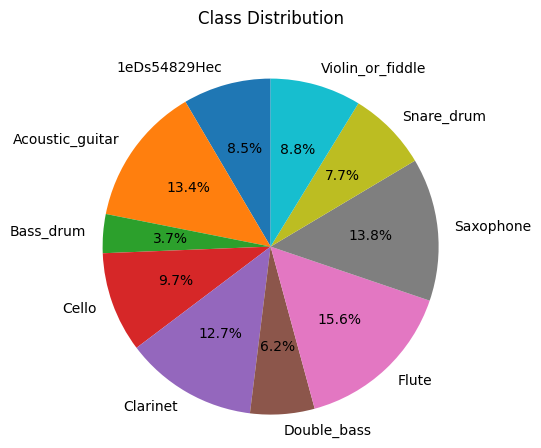

In [71]:
fig, ax = plt.subplots()
ax.set_title("Class Distribution", y=1.08)
ax.pie(class_dist,labels=class_dist.index,autopct='%1.1f%%',shadow=False,startangle=90)
ax.axis('equal')
plt.show()
speech_df.reset_index(inplace=True)

### Visualisations of the Time Series & FFTs, Filter Banks and MFCCs

In [72]:
# Create the dictionaries to store the data
signals = {}
fft = {}
fbank = {}
mfccs = {}

# Create dictionaries to hold the cleaned data
cleaned_signals = {}
cleaned_fft = {}
cleaned_fbank = {}
cleaned_mfccs = {}

### Generate Time Series

In [74]:
# For each of the classes, get one audio file and plot
for c in classes:
    wav_file = speech_df[speech_df.label == c].iloc[0,0]
    signal, rate = librosa.load('/content/drive/My Drive/labproject/wavfiles/'+wav_file,sr=44100) # 44100 is the sampling rate

    signals[c] = signal

    fft[c] = calc_fft(signal,rate) # Calculate the Fast Fourier Transform

    # Filter bank in log. 26 is a standard value for the filter.  nfft is the window length
    bank = logfbank(signal[:rate],rate,nfilt=26,nfft=1103).T
    fbank[c] = bank

    # Generate the Mel-Frequency Ceptrum Coefficient
    mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T
    mfccs[c] = mel

### Plot the Signals

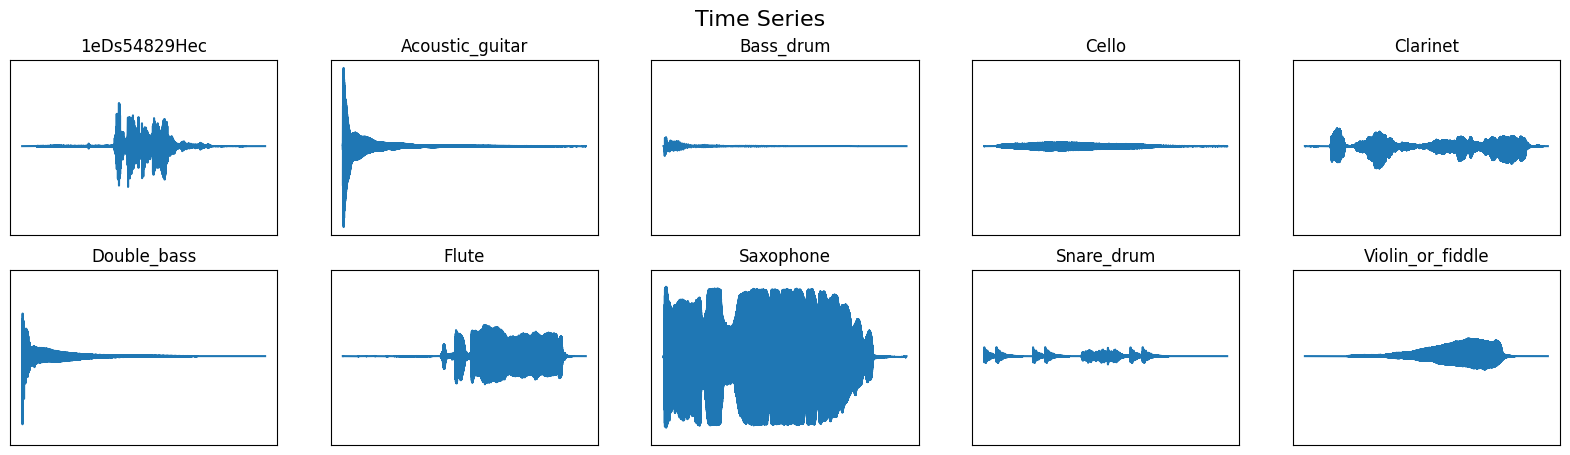

In [75]:
# Some have alot of noise begining and end of the signal and needs to be removed since there is no signal i.e. Noise threshold detection
plot_signals(signals)
plt.show()

### Plot the FFTs

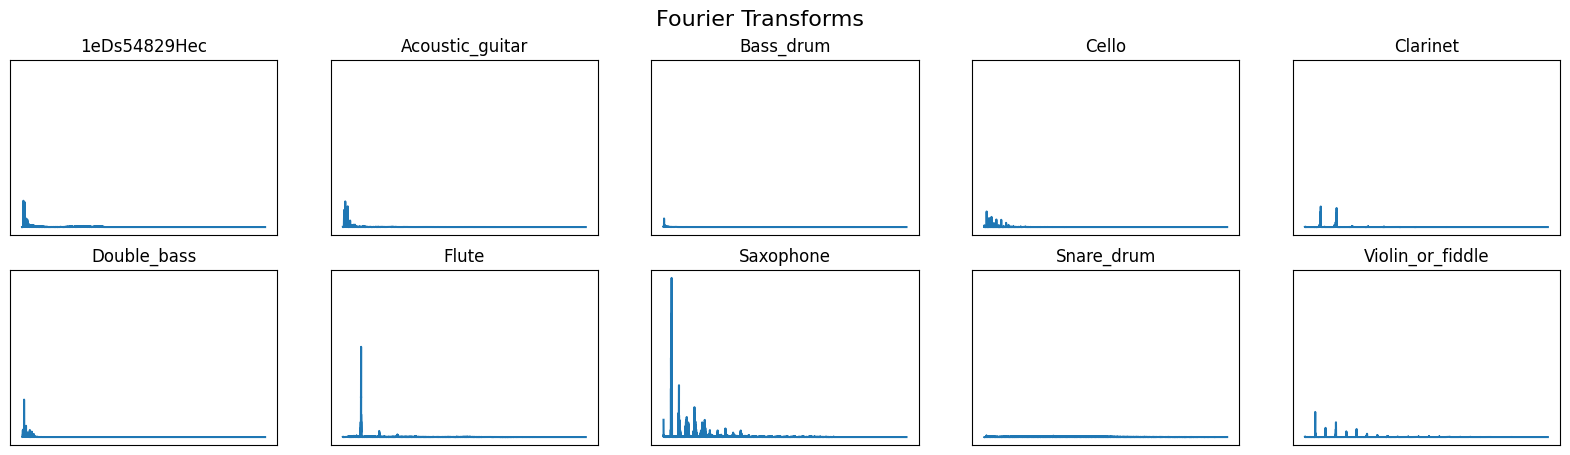

In [76]:
plot_fft(fft)
plt.show()

### Plot the Filter Banks

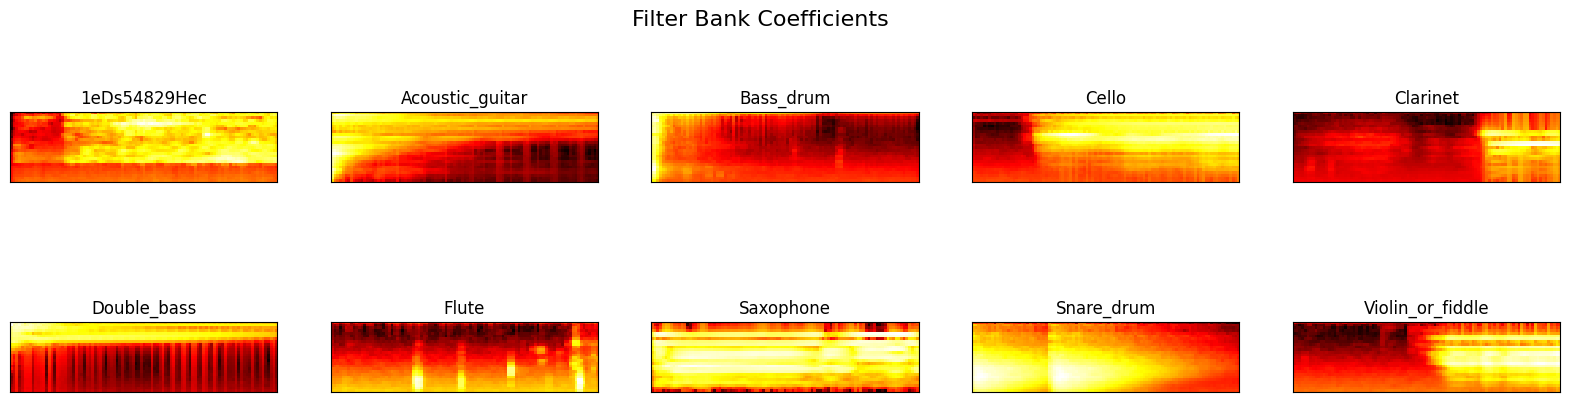

In [77]:
plot_fbank(fbank)
plt.show()

### Plot the MFCCs

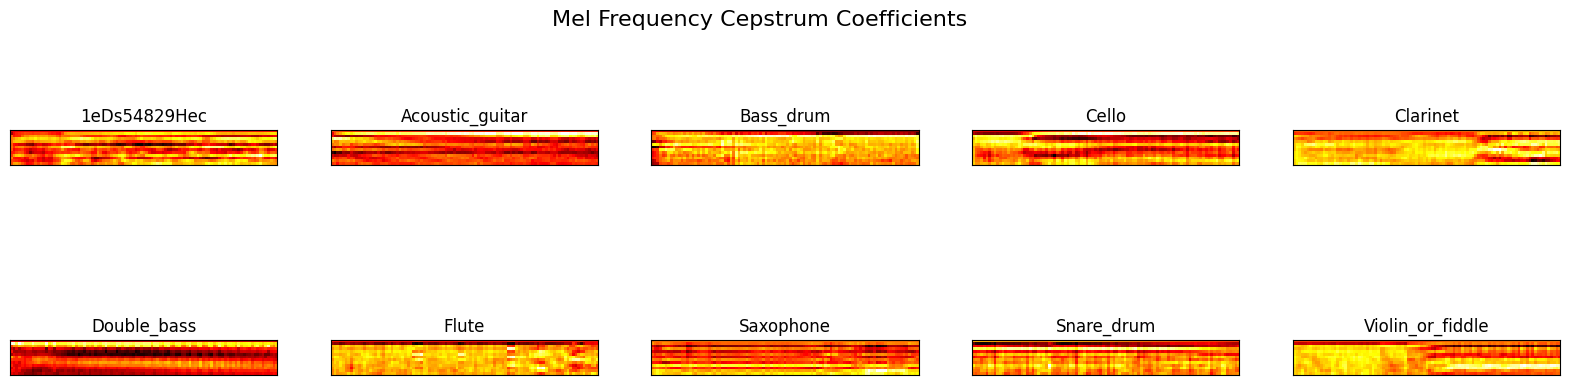

In [78]:
# When you do the Discrete Cosine Transform (DCT) on the filter banks, you get a more refined representation ready to be used
# for machine learning
plot_mfccs(mfccs)
plt.show()

### Removing the Dead Space in the Audio Files

In [81]:
# Generate Time Series
for cleaned_c in classes:
    cleaned_wav_file = speech_df[speech_df.label == cleaned_c].iloc[0,0]
    signal, rate = librosa.load('/content/drive/My Drive/labproject/wavfiles/'+cleaned_wav_file,sr=44100) # 44100 is the sampling rate
    mask = envelop(signal,rate,0.0005) # Call the envelop method
    signal = signal[mask]
    cleaned_signals[cleaned_c] = signal
    cleaned_fft[cleaned_c] = calc_fft(signal,rate)
    cleaned_bank = logfbank(signal[:rate],rate,nfilt=26,nfft=1103).T
    cleaned_fbank[cleaned_c] = cleaned_bank
    cleaned_mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T
    cleaned_mfccs[cleaned_c] = cleaned_mel

### View the graphs again without the dead signals

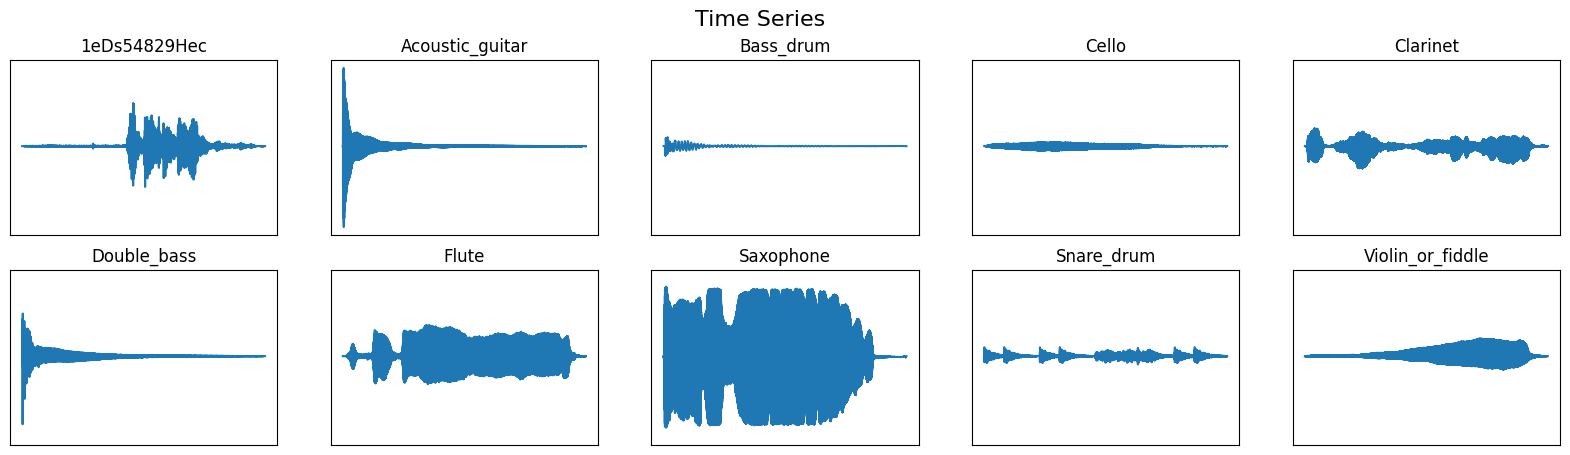

In [82]:
plot_signals(cleaned_signals)
plt.show()

### Downsampling the Audio

In [91]:
import os

clean_dir = "/content/drive/My Drive/labproject/clean"

# Create the 'clean' directory inside Google Drive if it doesn't exist
if not os.path.exists(clean_dir):
    os.makedirs(clean_dir)

if len(os.listdir(clean_dir)) == 0:
    for f in tqdm(speech_df.fname):
        signal, rate = librosa.load('/content/drive/My Drive/labproject/wavfiles/'+f, sr=16000)
        mask = envelop(signal, rate, 0.0005)  # To remove dead spots in the audio
        wavfile.write(filename=os.path.join(clean_dir, f), rate=rate, data=signal[mask])


100%|██████████| 300/300 [00:13<00:00, 21.59it/s]


## Next Classs Contents

**Train the model using an RNN and a CNN**

## **====================== END ====================**